# Nasdaq Composite 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'IXIC'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='1y', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-20 00:00:00-04:00,16185.759766,16377.440430,16127.480469,16369.410156,5298380000,0.0,0.0
2024-03-21 00:00:00-04:00,16517.240234,16538.859375,16393.900391,16401.839844,5134740000,0.0,0.0
2024-03-22 00:00:00-04:00,16387.830078,16467.619141,16361.000000,16428.820312,4339930000,0.0,0.0
2024-03-25 00:00:00-04:00,16335.299805,16441.169922,16315.719727,16384.470703,4636940000,0.0,0.0
2024-03-26 00:00:00-04:00,16446.849609,16476.380859,16312.950195,16315.700195,5144260000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-13 00:00:00-04:00,17598.560547,17621.910156,17239.439453,17303.009766,7147050000,0.0,0.0
2025-03-14 00:00:00-04:00,17523.300781,17773.480469,17491.080078,17754.089844,7093850000,0.0,0.0
2025-03-17 00:00:00-04:00,17722.539062,17925.939453,17645.869141,17808.660156,6306340000,0.0,0.0


In [3]:
df0 = ticker.history(period='3y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-21 00:00:00-04:00,13860.389648,13945.809570,13682.549805,13838.459961,5673940000,0.0,0.0
2022-03-22 00:00:00-04:00,13866.429688,14141.070312,13857.290039,14108.820312,5445100000,0.0,0.0
2022-03-23 00:00:00-04:00,13990.349609,14152.139648,13921.650391,13922.599609,5024230000,0.0,0.0
2022-03-24 00:00:00-04:00,14001.320312,14193.549805,13897.200195,14191.839844,5149520000,0.0,0.0
2022-03-25 00:00:00-04:00,14194.719727,14218.759766,14010.790039,14169.299805,5585100000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-13 00:00:00-04:00,17598.560547,17621.910156,17239.439453,17303.009766,7147050000,0.0,0.0
2025-03-14 00:00:00-04:00,17523.300781,17773.480469,17491.080078,17754.089844,7093850000,0.0,0.0
2025-03-17 00:00:00-04:00,17722.539062,17925.939453,17645.869141,17808.660156,6306340000,0.0,0.0


## Moving Median

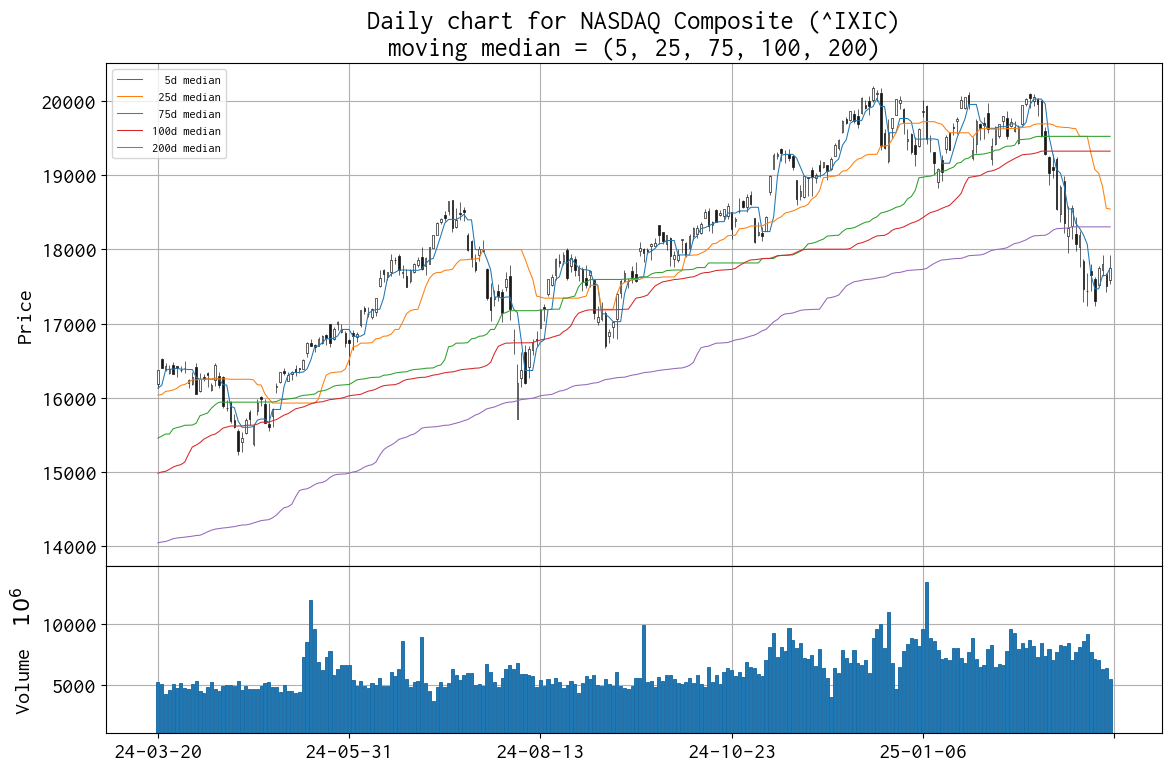

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax[0]),
]   

mpf.plot(
    df, type='candle', style='default',
    volume=ax[1],
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)
ax[0].set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax[0].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-18 00:00:00-04:00,17662.570312,17682.919922,17431.669922,17504.119141,6450530000,0.0,0.0
2025-03-19 00:00:00-04:00,17590.099609,17917.544922,17533.935547,17750.791016,5495254000,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-18 00:00:00-04:00    17504.119141
2025-03-19 00:00:00-04:00    17750.791016
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-18 00:00:00-04:00           NaN
2025-03-19 00:00:00-04:00    246.671875
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-19 00:00:00-04:00    160.691406
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-03-13 00:00:00-04:00    18069.259766
2025-03-14 00:00:00-04:00    17754.089844
2025-03-17 00:00:00-04:00    17754.089844
2025-03-18 00:00:00-04:00    17648.449219
2025-03-19 00:00:00-04:00    17648.449219
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-03-13 00:00:00-04:00    18285.160156
2025-03-14 00:00:00-04:00    18196.220703
2025-03-17 00:00:00-04:00    18069.259766
2025-03-18 00:00:00-04:00    17808.660156
2025-03-19 00:00:00-04:00    17754.089844
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-03-13 00:00:00-04:00    19181.094727
2025-03-14 00:00:00-04:00    19050.825195
2025-03-17 00:00:00-04:00    18936.834961
2025-03-18 00:00:00-04:00    18700.004883
2025-03-19 00:00:00-04:00    18548.575195
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-03-13 00:00:00-04:00    19517.315430
2025-03-14 00:00:00-04:00    19500.455078
2025-03-17 00:00:00-04:00    19488.234375
2025-03-18 00:00:00-04:00    19484.280273
2025-03-19 00:00:00-04:00    19484.280273
Name: Close, dtype: float64

## Robust Bollinger's bands

In [13]:
period = 20
calc_robust_bollinger(df0, period)
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Median,Q1,Q3,Lower,Upper
Date,,,,,,,,,,,,
2022-03-21 00:00:00-04:00,13860.389648,13945.809570,13682.549805,13838.459961,5673940000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-22 00:00:00-04:00,13866.429688,14141.070312,13857.290039,14108.820312,5445100000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-23 00:00:00-04:00,13990.349609,14152.139648,13921.650391,13922.599609,5024230000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-24 00:00:00-04:00,14001.320312,14193.549805,13897.200195,14191.839844,5149520000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-25 00:00:00-04:00,14194.719727,14218.759766,14010.790039,14169.299805,5585100000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13 00:00:00-04:00,17598.560547,17621.910156,17239.439453,17303.009766,7147050000,0.0,0.0,18936.834961,18262.925293,19723.872070,16071.505127,21915.292236
2025-03-14 00:00:00-04:00,17523.300781,17773.480469,17491.080078,17754.089844,7093850000,0.0,0.0,18700.004883,18164.480469,19629.417480,15967.074951,21826.822998
2025-03-17 00:00:00-04:00,17722.539062,17925.939453,17645.869141,17808.660156,6306340000,0.0,0.0,18548.575195,17990.467285,19346.199707,15956.868652,21379.798340


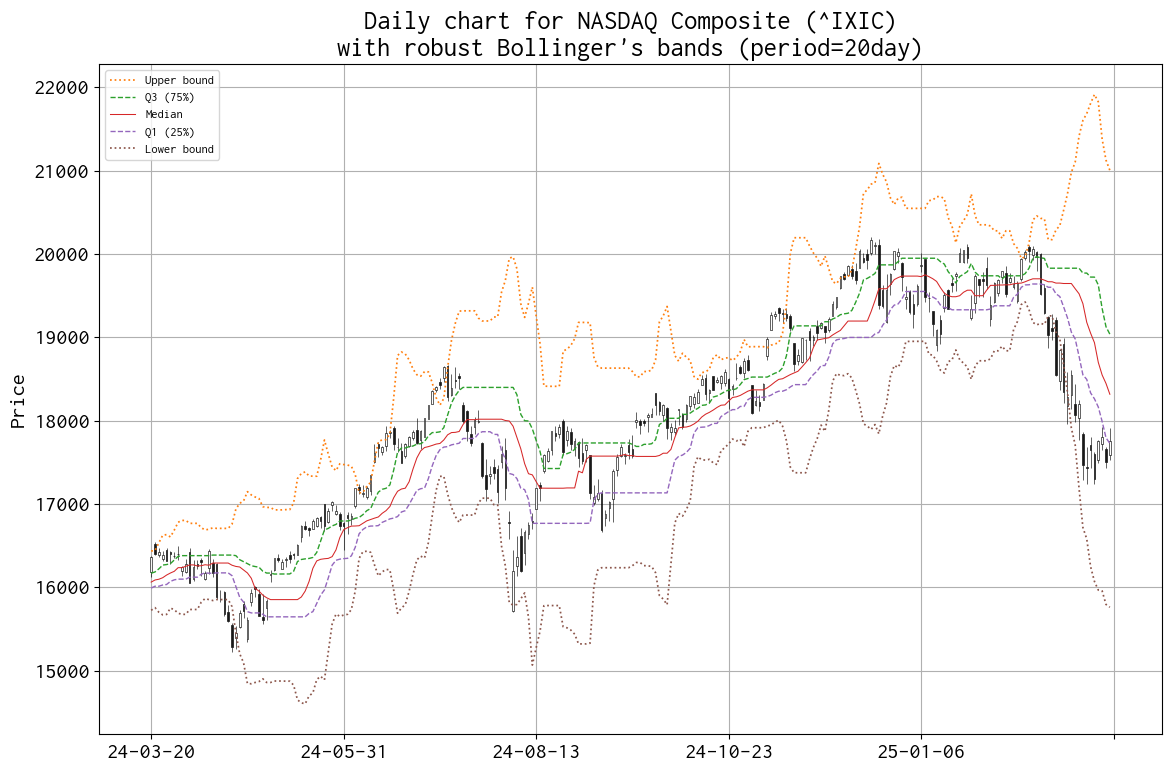

In [14]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
mv_median = df0['Median']
mv_q1 = df0['Q1']
mv_q3 = df0['Q3']
mv_lower = df0['Lower']
mv_upper = df0['Upper']

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger\'s bands (period=%dday)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger\'s bands (period=%dday)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

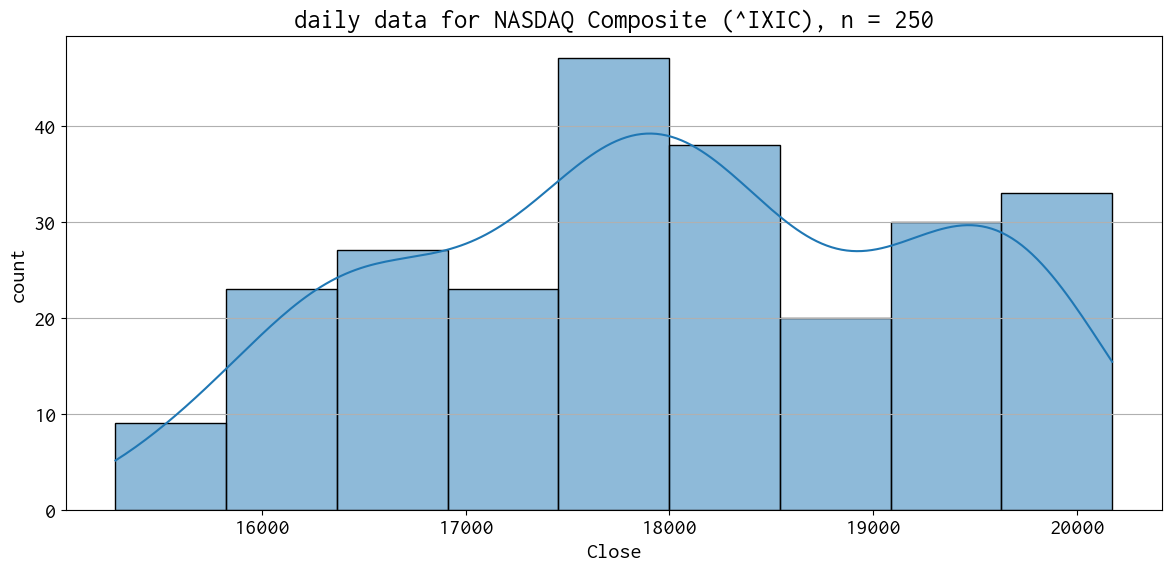

In [15]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(12, 6))
#ax = fig.add_axes(111)
ax = fig.add_subplot(111)

sns.histplot(
    df['Close'],
    kde=True,
    ax=ax
)

ax.set_xlabel("Close")
ax.set_ylabel("count")
ax.set_title('daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)))
ax.grid(axis = 'y')

plt.tight_layout()
plt.savefig('report_daily_histogram_%s.png' % code)
plt.show()